In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import os
import statistics as stats

# Read all CSV files and store them in the list with their filenames
dfs1=[]
for i in range(1,21):
        #file=f"tek{i:04d}ALL.csv"
        file=f"../casb1/averages/new/ch{i}.csv"
        df = pd.read_csv(file,skiprows=21,names=["Time", "CH1", "CH3", "CH4"])
        # Ensure values are numeric
        df.iloc[:, 0] = pd.to_numeric(df.iloc[:, 0], errors='coerce') 
        df.iloc[:, 1] = pd.to_numeric(df.iloc[:, 1], errors='coerce')
        df.iloc[:, 2] = pd.to_numeric(df.iloc[:, 2], errors='coerce')
        df.iloc[:, 3] = pd.to_numeric(df.iloc[:, 3], errors='coerce')
        dfs1.append((df, os.path.basename(file)))  # Store the reversed DataFrame with its filename
print(dfs1)

# Read all CSV files and store them in the list with their filenames
dfs2=[]
for i in range(0,20):
        file=f"../casb2/averages/tek{i:04d}ALL.csv"
        df = pd.read_csv(file,skiprows=21,names=["Time", "CH1", "CH2", "CH3"])
        # Ensure values are numeric
        df.iloc[:, 0] = pd.to_numeric(df.iloc[:, 0], errors='coerce') 
        df.iloc[:, 1] = pd.to_numeric(df.iloc[:, 1], errors='coerce')
        df.iloc[:, 2] = pd.to_numeric(df.iloc[:, 2], errors='coerce')
        df.iloc[:, 3] = pd.to_numeric(df.iloc[:, 3], errors='coerce')
        dfs2.append((df, os.path.basename(file)))  # Store the reversed DataFrame with its filename
print(dfs2)

[(             Time       CH1       CH3       CH4
0   -5.600000e-09  0.053169  0.039478 -0.007672
1   -5.200000e-09  0.053166  0.039452 -0.007656
2   -4.800000e-09  0.053100  0.039475 -0.007609
3   -4.400000e-09  0.053119  0.039484 -0.007703
4   -4.000000e-09  0.053209  0.039486 -0.007672
..            ...       ...       ...       ...
245  9.240000e-08  0.154747  0.074534 -0.040859
246  9.280000e-08  0.154613  0.074527 -0.041313
247  9.320000e-08  0.154628  0.074534 -0.040438
248  9.360000e-08  0.154497  0.074483 -0.040844
249  9.400000e-08  0.154350  0.074447 -0.040844

[250 rows x 4 columns], 'ch1.csv'), (             Time       CH1       CH3       CH4
0   -5.600000e-09  0.053109  0.039445 -0.007953
1   -5.200000e-09  0.053150  0.039430 -0.007766
2   -4.800000e-09  0.053072  0.039436 -0.007859
3   -4.400000e-09  0.053128  0.039461 -0.007719
4   -4.000000e-09  0.053181  0.039470 -0.007750
..            ...       ...       ...       ...
245  9.240000e-08  0.154703  0.074578 -0.041297


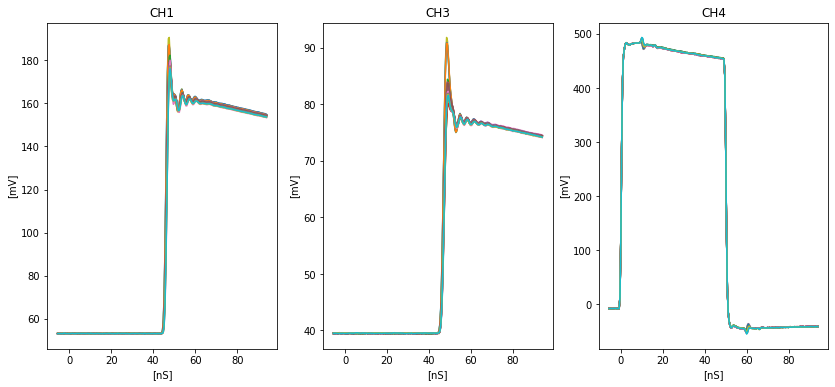

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))
for i in range(len(dfs1)):
    #print(dfs1[i][0])
    ax[0].plot(dfs1[i][0]["Time"]*1e9, dfs1[i][0]["CH1"]*1000)
    ax[1].plot(dfs1[i][0]["Time"]*1e9, dfs1[i][0]["CH3"]*1000)
    ax[2].plot(dfs1[i][0]["Time"]*1e9, dfs1[i][0]["CH4"]*1000)
ax[0].set_xlabel("[nS]")
ax[0].set_ylabel("[mV]")
ax[0].set_title("CH1")
ax[1].set_xlabel("[nS]")
ax[1].set_ylabel("[mV]")
ax[1].set_title("CH3")
ax[2].set_xlabel("[nS]")
ax[2].set_ylabel("[mV]")
ax[2].set_title("CH4");


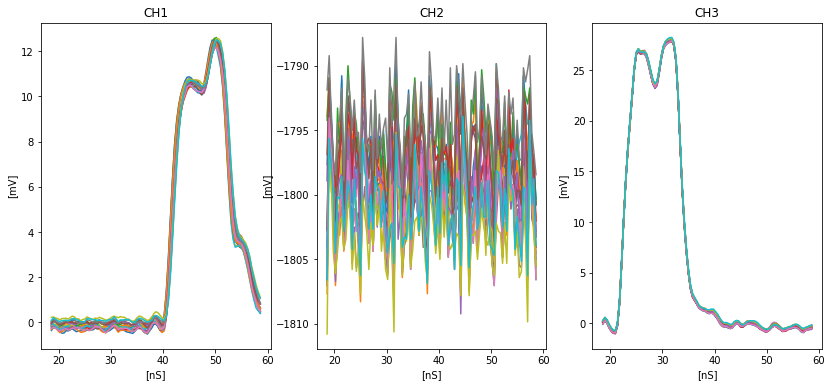

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))
for i in range(len(dfs1)):
    #print(dfs1[i][0])
    ax[0].plot(dfs2[i][0]["Time"]*1e9, dfs2[i][0]["CH1"]*1000-88.5)
    ax[1].plot(dfs2[i][0]["Time"]*1e9, dfs2[i][0]["CH2"]*1000)
    ax[2].plot(dfs2[i][0]["Time"]*1e9, dfs2[i][0]["CH3"]*1000-53)
ax[0].set_xlabel("[nS]")
ax[0].set_ylabel("[mV]")
ax[0].set_title("CH1")
ax[1].set_xlabel("[nS]")
ax[1].set_ylabel("[mV]")
ax[1].set_title("CH2")
ax[2].set_xlabel("[nS]")
ax[2].set_ylabel("[mV]")
ax[2].set_title("CH3");


In [16]:
def getPeakIndex(data,ped,thresh):
    peak=0
    peak_i=0
    thresh_i=0
    start=False
    neg_counter=0
    for i in range(len(data)):
        # start once we cross threshold
        if (data[i]-ped)>thresh and start==False:
            #print(f"Crossed threshold of {thresh} at {data[i]-ped}")
            start=True
            thresh_i=i
        if start==True and data[i]>peak:
            #print(f"Going up! At {data[i]-ped}")
            peak=data[i]
            peak_i=i
        elif start==True and data[i]<peak:
            #print(f"Going down! At {data[i]-ped}")
            neg_counter+=1
        # Previously crossed threshold and are now regressing
        if start==True and neg_counter>4:
            #print(f"Gone down {neg_counter} times! Stopping")
            break
    #print(f"Found peak at {data[peak_i]-ped}")
    return peak_i,thresh_i

def getPedestal(data,s,e):
    avg=0
    start=int(len(data)*s)
    end=int(len(data)*e)
    for i in range(start,end):
        avg+=data[i]
    return avg/(end-start)

def getLowCrossingTime(time,data,thresh,start_i):
    over=0 # first index where data crosses threshold
    under=0 # index before crossing threshold 
    # Cound down from starting index until we go below thresh
    for i in range(start_i,-1,-1):
        #print(i)
        if data[i]<thresh:
            under=i
            over=i+1
            break
    #print(under,over)
    m=(data[over]-data[under])/(time[over]-time[under])
    cross_time=time[under]+((thresh-data[under])/m)
    #print(time[under]*1e9,round(cross_time*1e9,2),time[over]*1e9)
    return cross_time

def getHighCrossingTime(time,data,thresh,start_i):
    over=0 # first index where data crosses threshold
    under=0 # index before crossing threshold 
    for i in range(start_i,len(data)):
        #print(i)
        if data[i]>thresh:
            over=i
            under=i-1
            break
    #print(under,over)
    m=(data[over]-data[under])/(time[over]-time[under])
    cross_time=time[under]+((thresh-data[under])/m)
    #print(time[under]*1e9,round(cross_time*1e9,2),time[over]*1e9)
    return cross_time

def getDelayTime(time,data,data2,low_thresh_pc,latch_thresh,latch_thresh2):
    ped=getPedestal(data,0.5,1)
    peak_i,thresh_i=getPeakIndex(data,ped,latch_thresh)
    amp=data[peak_i]-ped
    low_thresh=ped+amp*low_thresh_pc/100
    tLow=getLowCrossingTime(time,data,low_thresh,thresh_i)*1e9

    ped=getPedestal(data2,0.5,1)
    peak_i,thresh_i=getPeakIndex(data2,ped,latch_thresh2)
    amp=data2[peak_i]-ped
    low_thresh=ped+amp*low_thresh_pc/100
    tLow2=getLowCrossingTime(time,data2,low_thresh,thresh_i)*1e9

    #print(tLow,tLow2)
    return tLow-tLow2


def getRiseTime(time,data,threshLowPC,threshHighPC,thresh):
    ped=getPedestal(data,0.5,1)
    peak_i,thresh_i=getPeakIndex(data,ped,thresh)
    amp=data[peak_i]-ped
    #print("-------")
    #print(f"Pedestal {ped*1e3}")
    #print(f"Peak {data[peak_i]*1e3} at {time[peak_i]*1e9}")
    #print(f"Amplitude {amp*1e3}")
    #print(f"Starting at time {time[thresh_i]*1e9}")
    threshLow=ped+amp*threshLowPC/100
    threshHigh=ped+amp*threshHighPC/100
    tLow=getLowCrossingTime(time,data,threshLow,thresh_i)*1e9
    tHigh=getHighCrossingTime(time,data,threshHigh,thresh_i)*1e9
    #print(f"Crossed low of {(threshLow-ped)*1e3} at {tLow}")
    #print(f"Crossed high of {(threshHigh-ped)*1e3} at {tHigh}")
    rt=tHigh-tLow
    return round(rt,3)

print("-----------------------------------------------------")
print("CASB 1 Channel Delay Results")
print("350 MHz Scope")
#print("Baseline Restored Unity Analog Sum")
print("-----------------------------------------------------")
print("         Delay [ps]  ")
print("-----------------------------------------------------")
delays1=[0]*20
for i in range(len(dfs1)):
    delay=getDelayTime(dfs1[i][0].iloc[:,0],dfs1[i][0].iloc[:,1],dfs1[i][0].iloc[:,3],50,0.005,0.02)
    #print(i,delay)
    delays1[i]+=delay
base=min(delays1)
for i in range(len(delays1)):
    delays1[i]=1e3*(delays1[i]-base)
    print(f"CH{i+1:<6} {delays1[i]:>{7}.3f}")

print("-----------------------------------------------------")
print("CASB 2 Channel Delay Results")
print("350 MHz Scope")
#print("Baseline Restored Unity Analog Sum")
print("-----------------------------------------------------")
print("         Delay [ps]  ")
print("-----------------------------------------------------")
delays2=[0]*20
for i in range(len(dfs2)):
    delay=getDelayTime(dfs2[i][0].iloc[:,0],dfs2[i][0].iloc[:,1],dfs2[i][0].iloc[:,3],50,0.005,0.02)
    #print(i,delay)
    delays2[i]+=delay
base=min(delays2)
for i in range(len(delays2)):
    delays2[i]=1e3*(delays2[i]-base)
    print(f"CH{i+1:<6} {delays2[i]:>{7}.3f}")

#Should probably use average scope data for this...

-----------------------------------------------------
CASB 1 Channel Delay Results
350 MHz Scope
-----------------------------------------------------
         Delay [ps]  
-----------------------------------------------------
CH1      432.646
CH2      416.123
CH3      404.729
CH4      418.166
CH5      318.163
CH6      309.790
CH7      277.393
CH8      315.961
CH9       28.221
CH10      14.907
CH11       0.000
CH12      34.980
CH13     439.254
CH14     433.082
CH15     419.231
CH16     448.156
CH17     625.852
CH18     604.165
CH19     598.992
CH20     638.992
-----------------------------------------------------
CASB 2 Channel Delay Results
350 MHz Scope
-----------------------------------------------------
         Delay [ps]  
-----------------------------------------------------
CH1      471.503
CH2      528.365
CH3      466.002
CH4      560.100
CH5      421.111
CH6      394.602
CH7      492.383
CH8      472.895
CH9       49.202
CH10       0.000
CH11      76.519
CH12     113.962
CH

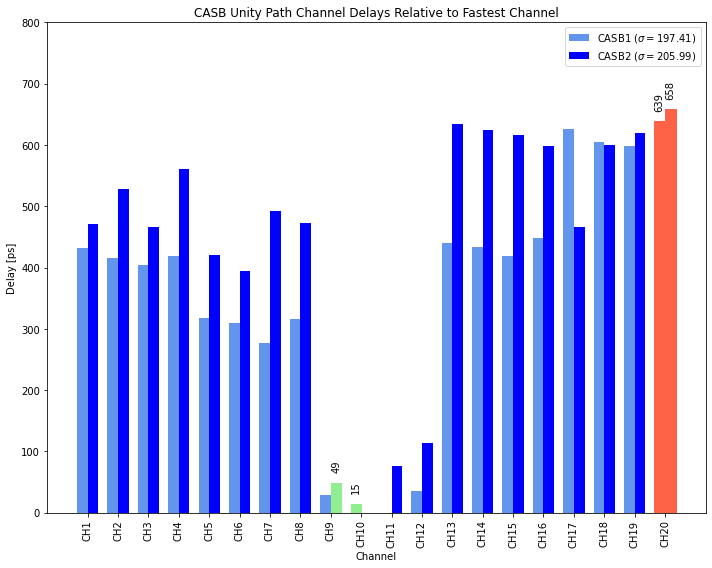

In [17]:
channels = ['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8','CH9','CH10','CH11','CH12','CH13','CH14','CH15','CH16','CH17','CH18','CH19','CH20']

def plot_delays(delays1, delays2, channels):
    """
    Create a bar plot showing both CASB1 and CASB2 delays for each channel.
    Highlights second lowest value in green and highest in red.
    
    Args:
        delays1 (list): List of delays for CASB1
        delays2 (list): List of delays for CASB2
        channels (list): List of channel names
    """
    # Set up the plot
    plt.figure(figsize=(10, 8))
    
    # Calculate positions for the bars
    x = np.arange(len(channels))
    width = 0.35  # Width of the bars
    
    # Create bars for both CASB1 and CASB2
    bars1 = plt.bar(x - width/2, delays1, width, label='CASB1',color='cornflowerblue')
    bars2 = plt.bar(x + width/2, delays2, width, label='CASB2',color='blue')
    
    # Find indices for CASB1
    min1_idx = delays1.index(min(delays1))
    temp_values1 = delays1.copy()
    temp_values1[min1_idx] = float('inf')
    second_min1_idx = temp_values1.index(min(temp_values1))
    max1_idx = delays1.index(max(delays1))
    
    # Find indices for CASB2
    min2_idx = delays2.index(min(delays2))
    temp_values2 = delays2.copy()
    temp_values2[min2_idx] = float('inf')
    second_min2_idx = temp_values2.index(min(temp_values2))
    max2_idx = delays2.index(max(delays2))
    
    # Highlight second lowest (green) and highest (red) values
    bars1[second_min1_idx].set_color('lightgreen')
    bars1[max1_idx].set_color('tomato')
    bars2[second_min2_idx].set_color('lightgreen')
    bars2[max2_idx].set_color('tomato')
    
    # Add value labels for second lowest and highest
    plt.text(x[second_min1_idx] - width/2, delays1[second_min1_idx]+20, 
             f"{delays1[second_min1_idx]:.0f}", ha='center', rotation=90)
    plt.text(x[max1_idx] - width/2, delays1[max1_idx]+20, 
             f"{delays1[max1_idx]:.0f}", ha='center', rotation=90)
    plt.text(x[second_min2_idx] + width/2, delays2[second_min2_idx]+20, 
             f"{delays2[second_min2_idx]:.0f}", ha='center', rotation=90)
    plt.text(x[max2_idx] + width/2, delays2[max2_idx]+20, 
             f"{delays2[max2_idx]:.0f}", ha='center', rotation=90)
    
    # Customize the plot
    plt.xlabel('Channel')
    plt.ylabel('Delay [ps]')
    plt.title('CASB Unity Path Channel Delays Relative to Fastest Channel')
    plt.xticks(x, channels, rotation=90)
    plt.ylim(0, 800)
    
    # Add standard deviations to the legend
    std1 = np.std(delays1)
    std2 = np.std(delays2)
    plt.legend([f'CASB1 ($\\sigma= {std1:.2f}$)', f'CASB2 ($\\sigma= {std2:.2f}$)'])
    
    plt.tight_layout()
    return plt.gcf()

# Create the combined plot
fig = plot_delays(delays1, delays2, channels)
plt.show()

/tmp/ipykernel_124373/286950793.py:107: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


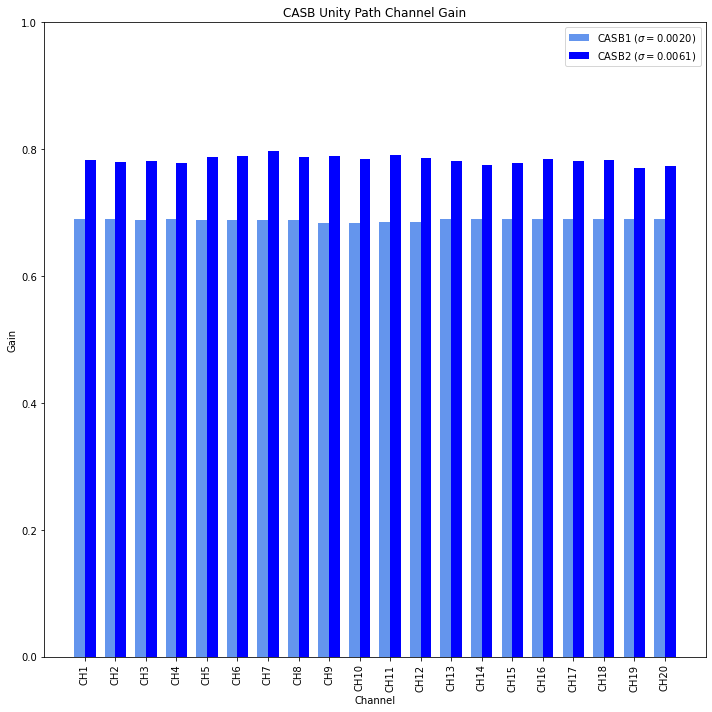

In [25]:
# def getPeakIndex(data,ped,thresh):
#     peak=0
#     peak_i=0
#     thresh_i=0
#     start=False
#     neg_counter=0
#     for i in range(len(data)):
#         if data[i]>peak:
#             peak=data[i]
#             peak_i=i
  
#     #print(f"Found peak at {data[peak_i]-ped}")
#     return peak_i,thresh_i


def getAmplitude(time,data,thresh,ped_start,ped_end,jump=False):
    ped=getPedestal(data,ped_start,ped_end)
    peak_i,thresh_i=getPeakIndex(data,ped,thresh)
    if jump:
        amp=data[peak_i+70]-ped
    else:
        amp=data[peak_i]-ped
    #print(f"ped {ped} time peak {time[peak_i]*1e9} time peak {data[peak_i]} amp {amp}")
    return amp

gain1=[]
for i in range(len(dfs1)):
    input=getAmplitude(dfs1[i][0]["Time"],dfs1[i][0]["CH1"],0.05,0,0.4,jump=True)
    output=amp=getAmplitude(dfs1[i][0]["Time"],dfs1[i][0]["CH3"],0.02,0,0.4,jump=True)
    #print(input,output)
    gain1.append(2*output/input)

gain2=[]
for i in range(len(dfs2)):
    input=getAmplitude(dfs2[i][0]["Time"],dfs2[i][0]["CH3"],0.02,0.75,1)
    output=amp=getAmplitude(dfs2[i][0]["Time"],dfs2[i][0]["CH1"],0.008,0,0.4)
    #print(input,output)
    gain2.append(2*output/input)

def plot_gains(delays1, delays2, channels):
    """
    Create a bar plot showing both CASB1 and CASB2 delays for each channel.
    Highlights second lowest value in green and highest in red.
    
    Args:
        delays1 (list): List of delays for CASB1
        delays2 (list): List of delays for CASB2
        channels (list): List of channel names
    """
    # Set up the plot
    plt.figure(figsize=(10,10))
    
    # Calculate positions for the bars
    x = np.arange(len(channels))
    width = 0.35  # Width of the bars
    
    # Create bars for both CASB1 and CASB2
    bars1 = plt.bar(x - width/2, delays1, width, label='CASB1',color='cornflowerblue')
    bars2 = plt.bar(x + width/2, delays2, width, label='CASB2',color='blue')
    
    # Find indices for CASB1
    min1_idx = delays1.index(min(delays1))
    temp_values1 = delays1.copy()
    temp_values1[min1_idx] = float('inf')
    second_min1_idx = temp_values1.index(min(temp_values1))
    max1_idx = delays1.index(max(delays1))
    
    # Find indices for CASB2
    min2_idx = delays2.index(min(delays2))
    temp_values2 = delays2.copy()
    temp_values2[min2_idx] = float('inf')
    second_min2_idx = temp_values2.index(min(temp_values2))
    max2_idx = delays2.index(max(delays2))
    
    # # Highlight second lowest (green) and highest (red) values
    # bars1[second_min1_idx].set_color('lightgreen')
    # bars1[max1_idx].set_color('tomato')
    # bars2[second_min2_idx].set_color('lightgreen')
    # bars2[max2_idx].set_color('tomato')
    
    # # Add value labels for second lowest and highest
    # plt.text(x[second_min1_idx] - width/2, delays1[second_min1_idx]+0.01, 
    #          f"{delays1[second_min1_idx]:.2f}", ha='center', rotation=90)
    # plt.text(x[max1_idx] - width/2, delays1[max1_idx]+0.01, 
    #          f"{delays1[max1_idx]:.2f}", ha='center', rotation=90)
    # plt.text(x[second_min2_idx] + width/2, delays2[second_min2_idx]+0.01, 
    #          f"{delays2[second_min2_idx]:.2f}", ha='center', rotation=90)
    # plt.text(x[max2_idx] + width/2, delays2[max2_idx]+0.01, 
    #          f"{delays2[max2_idx]:.2f}", ha='center', rotation=90)
    
    # Customize the plot
    plt.xlabel('Channel')
    plt.ylabel('Gain')
    plt.title('CASB Unity Path Channel Gain')
    plt.xticks(x, channels, rotation=90)
    plt.ylim(0, 1)
    
    # Add standard deviations to the legend
    std1 = np.std(delays1)
    std2 = np.std(delays2)
    plt.legend([f'CASB1 ($\\sigma= {std1:.4f}$)', f'CASB2 ($\\sigma= {std2:.4f}$)'])
    
    plt.tight_layout()
    return plt.gcf()

fig = plot_gains(gain1,gain2,channels)
fig.show()


In [19]:
# fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# for i in range(len(dfs2)):
#     ax[0].plot(dfs2[0][0].iloc[:, 0]*1e9, (dfs2[0][0].iloc[:, 1]-getPedestal(dfs2[0][0].iloc[:, 1],0.5,1))*1000,label=dfs2[0][1][:-4])
#     ax[0].plot(dfs2[0][0].iloc[:, 0]*1e9, (dfs2[0][0].iloc[:, 2]-getPedestal(dfs2[0][0].iloc[:, 2],0.5,1))*1000,label=dfs2[0][1][:-4])
#     ax[0].plot(dfs2[0][0].iloc[:, 0]*1e9, (dfs2[0][0].iloc[:, 3]-getPedestal(dfs2[0][0].iloc[:, 3],0.5,1))*1000,label=dfs2[0][1][:-4])
#     ax[1].plot(dfs2[0][0].iloc[:, 0]*1e9, (dfs2[0][0].iloc[:, 1]-getPedestal(dfs2[0][0].iloc[:, 1],0.5,1))*1000,label=dfs2[0][1][:-4])
#     ax[1].plot(dfs2[0][0].iloc[:, 0]*1e9, (dfs2[0][0].iloc[:, 2]-getPedestal(dfs2[0][0].iloc[:, 2],0.5,1))*1000,label=dfs2[0][1][:-4])
# #ax[0].plot(dfs[0][0].iloc[:, 0], dfs[0][0].iloc[:, 2], color='blue', linestyle='-', label="$\\theta=0$\u00B0 (Vertical Polarizer)")
# #ax[0].set_xlim(0,100)
# #ax[1].set_xlim(40,60)
# ax[0].set_xlabel("[nS]")
# #ax[1].set_xlabel("[nS]")
# ax[0].set_ylabel("[mV]")
# #ax[1].set_ylabel("[mV]")
# #ax[0].legend(loc='upper left')
# #ax[1].legend(loc='upper left')
# ax[0].grid()
# ax[1].grid()







In [20]:
# std_dev=np.std(unity_gain)
# min_index = unity_gain.index(min(unity_gain))
# max_index = unity_gain.index(max(unity_gain))
# # Create bar plot
# bars = plt.bar(channels,unity_gain,color='silver')
# # Set the color of the bar with the lowest value to gold
# bars[min_index].set_color('tomato')
# bars[max_index].set_color('lightgreen')
# # Add value label on top of the bar with the lowest value, rotated 90 degrees
# plt.text(min_index, unity_gain[min_index], f"{unity_gain[min_index]:.2f}", ha='center', rotation=90)
# plt.text(max_index, unity_gain[max_index], f"{unity_gain[max_index]:.2f}", ha='center', rotation=90)
# # Rotate the x-axis labels
# plt.xticks(rotation=90)
# plt.ylabel('Gain')
# plt.title('Gain of CASB "Unity" Path')
# # Add standard deviation to the legend
# plt.legend([f'$\\sigma= {std_dev:.2f}$'])
# plt.ylim(0.4,0.6)
# # Show the plot
# plt.show()

In [21]:
# std_dev=np.std(attn_gain)
# min_index = attn_gain.index(min(attn_gain))
# max_index = attn_gain.index(max(attn_gain))
# # Create bar plot
# bars = plt.bar(channels,attn_gain,color='silver')
# # Set the color of the bar with the lowest value to gold
# bars[min_index].set_color('tomato')
# bars[max_index].set_color('lightgreen')
# # Add value label on top of the bar with the lowest value, rotated 90 degrees
# plt.text(min_index, attn_gain[min_index], f"{attn_gain[min_index]:.2f}", ha='center', rotation=90)
# plt.text(max_index, attn_gain[max_index], f"{attn_gain[max_index]:.2f}", ha='center', rotation=90)
# # Rotate the x-axis labels
# plt.xticks(rotation=90)
# plt.ylabel('Gain')
# plt.title('Gain of CASB "Attenuated" Path')
# # Add standard deviation to the legend
# plt.legend([f'$\\sigma= {std_dev:.2f}$'])
# plt.ylim(0.1,0.3)
# # Show the plot
# plt.show()